                                          Yuhai Li

# Random Numbers

## Implement an algorithm generating 10000 random numbers, with a uniform distribution between 0 and 1, following the Park and Miller formula.

In [79]:
class RandomNumber:
    
    def __init__(self, seed = 362355):
        self._seed = int(seed)
        self._a = 16807
        self._m = 2147483647
        
    def random(self):
        self._seed = self._a * self._seed % self._m
        return self._seed / self._m

In [2]:
import time
rand = RandomNumber(time.time())
nums = [rand.random() for i in range(10000)]

## Manually calculate and plot the distribution of these numbers, using different intervals to show the effect of the sampling frequency.

In [3]:
import matplotlib.pyplot as plt

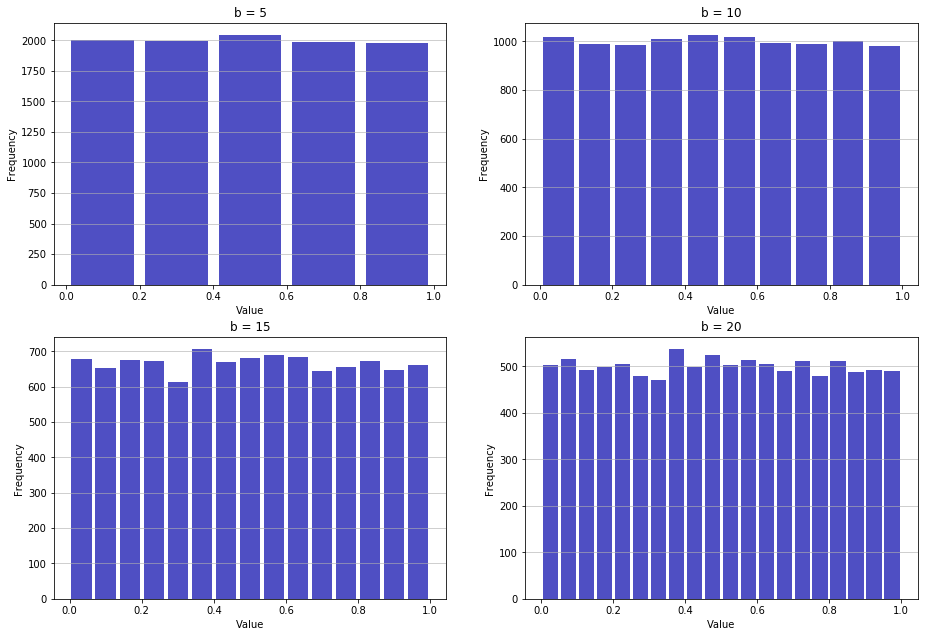

In [4]:
fig, a = plt.subplots(ncols=2, nrows=2, gridspec_kw={'left': 1, 'right': 3, 'top': 3, 'bottom': 1})
a = a.ravel()
for i, ax in enumerate(a):
    ax.hist(nums, bins=5 + i * 5, color='#0504aa', alpha=0.7, rwidth=0.85)
    ax.grid(axis='y', alpha=0.75)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.set_title('b = {}'.format(5 + i * 5))

Looks that the numbers generated are equally distributed. The distributions can be visualized from the above graphs. The frequencies in each range are approximately equal and converaged to the mean. 

# 1D random-walk model

## Implement an algorithm to run a 1D random walk with 1000 jumps. Take all constants equal to 1 (duration and length of each step).

In [5]:
from enum import Enum

In [6]:
class Direction(Enum):
    LEFT = -1
    RIGHT = 1

In [7]:
import time
class OneDRandomWalk:

    def __init__(self, orig, seed = time.time()):
        self._initPos = orig
        self._origin = orig
        self.rand = RandomNumber(int(seed))
    
    def get_dir(self):
        return Direction.RIGHT if self.rand.random() > 0.5 else Direction.LEFT
        
    def move(self):
        res = self._origin
        self._origin = self._origin + self.get_dir().value
        return res
    
    def reset(self):
        self._origin = self._initPos

In [8]:
randomWalk = OneDRandomWalk(0)
x = [randomWalk.move() for i in range(1000)]

## Plot x and x2 with respect to the step number.

In [9]:
x2 = [i * i for i in x]
step = [i for i in range(len(x))]

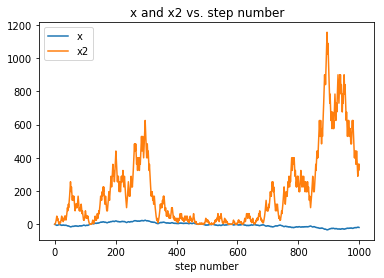

In [10]:
plt.plot(step, x, label='x')
plt.plot(step, x2, label='x2')
plt.title('x and x2 vs. step number')
plt.xlabel('step number')
plt.legend()
plt.show()

## By averaging multiple simulations, check that the mean-square displacement tends to a linear function of the number of steps, with a slope of 1.

In [11]:
ITER = 50000
STEPS = 1000

In [12]:
import numpy as np
atoms = [OneDRandomWalk(0, i * time.time()) for i in range(ITER)]
msd = [np.mean([a.move()**2 for a in atoms]) for i in range(STEPS)]        

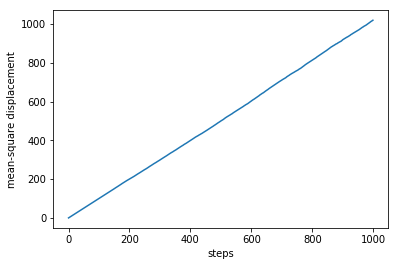

In [13]:
plt.plot(msd)
plt.xlabel('steps')
plt.ylabel('mean-square displacement')
plt.show()

# Vapor deposition simulation 

In [14]:
class TwoDDirection(Enum):
    UP = [1, 0]
    DOWN = [-1, 0]
    LEFT = [0, -1]
    RIGHT = [0, 1]

In [73]:
from copy import deepcopy
class Atom:
        def __init__(self):
            self._rand = RandomNumber(time.time())
            self._nextDirection = None
        
        def new_direction(self):
            num = self._rand.random()
            if num > 0 and num < 0.25:
                return TwoDDirection.UP
            elif num < 0.5:
                return TwoDDirection.DOWN
            elif num < 0.75:
                return TwoDDirection.LEFT
            else:
                return TwoDDirection.RIGHT
        
        def get_direction(self):
            self._nextDirection = self.new_direction()
            return self._nextDirection
        
class VaporDepositionSimulator:
    
    def __init__(self, bin = 5):
        self._ROW = 20
        self._COL = 10
        self._lattice = np.zeros(shape=(self._ROW, self._COL))
        self._bin = bin
        self._rand = RandomNumber(time.time())
        self._pos = [0, 0]
        self._count = 0
        self._snapshots = []
    
    def get_value(self, pos):
        if pos[0] < 0:
            return -1
        pos[1] = pos[1] % self._COL
        return self._lattice[pos[0]][pos[1]]
    
    def is_frozen(self):
        return True if self._pos[0] == self._ROW - 1 or any([self.get_value(self._pos + di.value) == 1 for di in TwoDDirection]) else False
        
    def move(self, direction):
        self._pos = (self._pos + direction.value) % (self._ROW, self._COL)
    
    def can_move(self, direction):
        return self.get_value(self._pos + direction.value) == 0
    
    def terminate(self):
        self._lattice[self._pos[0]][self._pos[1]] = 1
    
    def reset(self):
        self._pos = np.array([0, int(self._rand.random() * self._COL)])
    
    def _reshape_snapshots(self):
        n_col = 5
        n_row = int(len(self._snapshots) / n_col) if len(self._snapshots) % n_col == 0 else int(len(self._snapshots)) + 1
        temp = []
        for i in range(n_row):
            row = []
            for j in range(n_col):
                if i * n_col + j >= len(self._snapshots):
                    break
                row.append(self._snapshots[i * n_col + j])
            temp.append(row)
        self._snapshots = temp
        
    def run(self):
        while(np.sum(self._lattice[0]) == 0):
            self.reset()
            atom = Atom()
            self._count = self._count + 1
            next_direction = atom.get_direction()
            while(not self.is_frozen()):
                while(not self.can_move(next_direction)):
                    next_direction = atom.get_direction()
                self.move(next_direction)
            self.terminate()
            if(self._count % self._bin == 0):
                self._snapshots.append((deepcopy(self._lattice), self._count))
        if not (self._count % self._bin == 0):
            self._snapshots.append((deepcopy(self._lattice), self._count))
        self._reshape_snapshots()

    def show(self): 
        for row in self._snapshots:
            n_col = len(row)
            fig, axs = plt.subplots(1, n_col)
            fig.set_figheight(20)
            fig.set_figwidth(10)

            for i, (matrix, n) in enumerate(row):
                col = i % n_col

                axs[col].set_xticks(range(self._COL))
                axs[col].set_yticks(range(self._ROW))
                axs[col].set_title("{} atoms".format(str(n)))
                axs[col].imshow(matrix)
                
    def porosity(self):
        n = self._ROW * self._COL
        return (n - np.sum(self._lattice)) / n

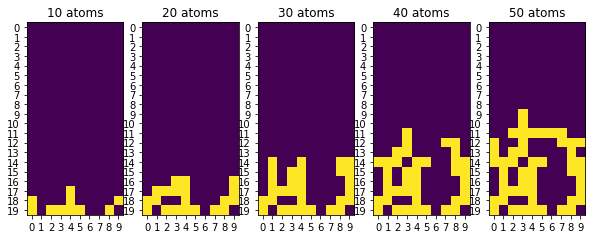

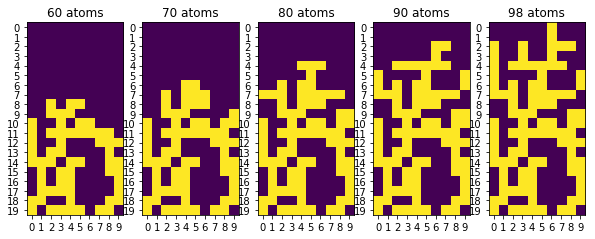

In [77]:
simulator = VaporDepositionSimulator(bin=10)
simulator.run()
simulator.show()

The porosity of the deposited Si phase is:

In [78]:
print(simulator.porosity())

0.51
